# Zipping Calibration Version Comparison



In [5]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [6]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [7]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping_calibration']

# which iteration name should we use?
iteration_names = ['zipping_calibration_sona_pilot_2','zipping_calibration_sona_masks_0']

# variables to check integrity of data
# numTrials = 8

In [8]:
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
#                         {'datatype':'trial_end'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_zip = pd.DataFrame(query)
df_zip

,_id,rt,stimulus,response,response_correct,stimURL,practice,composite_id,composite_duration,gap_duration,...,datatype,experimentName,iterationName,workerID,gameID,block_number,condition,composite_talls_name,response_key_dict,mask
0,62194afc5698fd325c09fc62,1785.1,../img/practice_trials/practice_0_composite.png,m,1,https://tower-4-block-unique-silhouettes-compo...,True,None,600,400,...,trial_end,block_construction_zipping,zipping_calibration_sona_pilot_2,None,9491-1455e790-8de3-4d4c-b880-3a6f301e7782,NaN,NaN,NaN,NaN,NaN
1,62194b005698fd325c09fc63,668.2,../img/practice_trials/practice_0_composite.png,z,0,https://tower-4-block-unique-silhouettes-compo...,True,None,600,400,...,trial_end,block_construction_zipping,zipping_calibration_sona_pilot_2,None,9491-1455e790-8de3-4d4c-b880-3a6f301e7782,NaN,NaN,NaN,NaN,NaN
2,62194b045698fd325c09fc64,1086.9,../img/practice_trials/practice_0_composite.png,z,1,https://tower-4-block-unique-silhouettes-compo...,True,None,600,400,...,trial_end,block_construction_zipping,zipping_calibration_sona_pilot_2,None,9491-1455e790-8de3-4d4c-b880-3a6f301e7782,NaN,NaN,NaN,NaN,NaN
3,62194b095698fd325c09fc65,1435.1,../img/practice_trials/practice_0_composite.png,z,1,https://tower-4-block-unique-silhouettes-compo...,True,None,600,400,...,trial_end,block_construction_zipping,zipping_calibration_sona_pilot_2,None,9491-1455e790-8de3-4d4c-b880-3a6f301e7782,NaN,NaN,NaN,NaN,NaN
4,62194b215698fd325c09fc69,1303.8,https://tower-4-block-unique-silhouettes-compo...,m,1,https://tower-4-block-unique-silhouettes-compo...,False,talls_102_116,50,450,...,trial_end,block_construction_zipping,zipping_calibration_sona_pilot_2,None,9491-1455e790-8de3-4d4c-b880-3a6f301e7782,0.0,common_wide,talls_102_116,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32259,622857675698fd325c0a8efa,442.1,https://zipping-composites-png-rerender.s3.ama...,z,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_097_102,500,500,...,trial_end,block_construction_zipping,zipping_calibration_sona_masks_0,38574,9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c,2.0,common_tall,talls_097_102,"{'valid': 'z', 'invalid': 'm'}",NaN
32260,6228576c5698fd325c0a8efb,543.2,https://zipping-composites-png-rerender.s3.ama...,z,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_121_126,500,500,...,trial_end,block_construction_zipping,zipping_calibration_sona_masks_0,38574,9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c,2.0,common_wide,talls_121_126,"{'valid': 'z', 'invalid': 'm'}",NaN
32261,622857715698fd325c0a8efc,699.7,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_097_102,500,500,...,trial_end,block_construction_zipping,zipping_calibration_sona_masks_0,38574,9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c,2.0,common_tall,talls_097_102,"{'valid': 'z', 'invalid': 'm'}",NaN
32262,622857765698fd325c0a8efd,977.9,https://zipping-composites-png-rerender.s3.ama...,m,1,https://zipping-composites-png-rerender.s3.ama...,False,talls_102_121,500,500,...,trial_end,block_construction_zipping,zipping_calibration_sona_masks_0,38574,9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c,2.0,rare,talls_102_121,"{'valid': 'z', 'invalid': 'm'}",NaN


In [9]:
# complete datasets
df_zip_trials = df_zip[~df_zip.condition.isna()]
df_zip_w_practice = df_zip.copy()

full_dataset_ids = (df_zip_trials.groupby('gameID').apply(len) == 144)\
                        .index[(df_zip_trials.groupby('gameID').apply(len) == 144)]
df_zip_trials = df_zip_trials.loc[df_zip.gameID.isin(full_dataset_ids)]

df_zip = df_zip_trials

In [101]:
# Filter out extreme outliers
df_zip_ppt_means_tmp = df_zip.groupby(['gameID']).mean()
df_zip = df_zip[~df_zip.gameID.isin(list(df_zip_ppt_means_tmp['rt'].index[df_zip_ppt_means_tmp['rt'] > 3000]))]

### Preprocessing

In [102]:
df_zip.loc[:,'common'] = ~(df_zip.condition == 'rare')
df_zip.loc[:,'trial_bin'] = np.round(df_zip.trial_num/12)

/Users/will/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### Create summary dataframes

In [103]:
games_to_iterations = df_zip[['gameID','iterationName']].groupby('gameID').first()
df_zip_ppt_mean = df_zip.groupby('gameID').mean().merge(games_to_iterations, how='left', on='gameID')
df_zip_block_mean = df_zip.groupby(['gameID','block_number']).mean().reset_index().merge(games_to_iterations, how='left', on='gameID')
df_zip_block_common_mean = df_zip.groupby(['gameID','block_number','common']).mean().reset_index().merge(games_to_iterations, how='left', on='gameID')

#### How many full datasets do we have for each version?

In [104]:
df_zip.groupby(['iterationName','composite_duration','gameID']).first().reset_index()\
    .groupby(['iterationName','composite_duration']).size()

iterationName                     composite_duration
zipping_calibration_sona_masks_0  50                    32
                                  100                   31
                                  200                   25
                                  300                   30
                                  500                   23
                                  800                   28
zipping_calibration_sona_pilot_2  50                    11
                                  100                   10
                                  200                   10
                                  300                    9
dtype: int64

## How difficult is this task?

<Figure size 720x432 with 0 Axes>

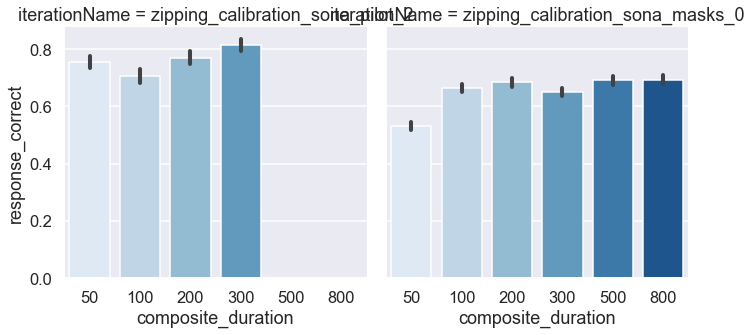

In [105]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            col = 'iterationName',
              y="response_correct", 
              x="composite_duration",
              kind='bar',
              palette='Blues')
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

People do very well in the version without masks, and less well with masks.

In general, longer composite exposures make the task easier.
For the mask version, it looks like we reach a plateau in accuracy at 200ms but there's something weird going on with the 300ms version.

##### Some notes about these versions that could explain this.
For 50 to 300 ms composite durations, we always display the potential parts 500ms after composite onset.
This means the gap between composite and parts gets *smaller*.
For 500 and 800ms composite durations, we increase this onset duration to 1000ms.
This means there are 500ms and 200ms gap between the composite and parts for these versions.

Why the hump in the mask versions?
There seems to be something going on around 300ms. 
Could this be something to do with the smaller gap?
I'd be surprised- in all of [50,100,200,300] the time between the start of the composite and the start of the parts is the same. Why would a smaller gap make a difference?
Could the rapid changes be offputting in some way? Might the rapid presentation of the mask be interfering with the memory of the composite in a way that wouldn't happen if the mask was more stable?

#### What is the distribution of performance?

<Figure size 720x432 with 0 Axes>

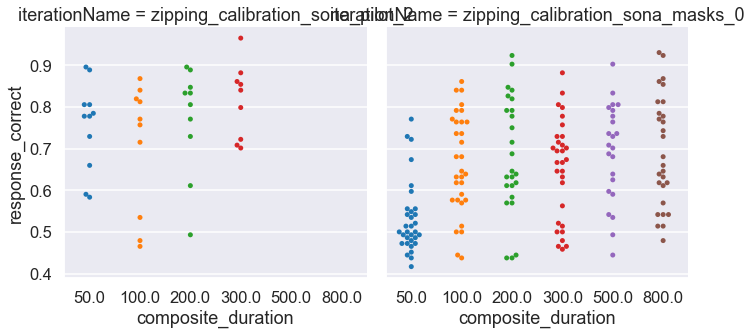

In [108]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip_ppt_mean, 
            col = 'iterationName',
              y="response_correct", 
              x="composite_duration",
              kind='swarm')
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

It looks like a lot of people are at change for the 50ms composite exposure. There are a handgul of people around chance for other exposures.



In [64]:
df_zip_block_mean

,gameID,block_number,rt,response_correct,practice,composite_duration,gap_duration,chunk_duration,compatible_trial,stimVersionInd,trial_num,trial_index,time_elapsed,common,iterationName
0,0122-4e1d44f5-f989-4e97-b611-a733135b8bd6,0.0,995.352083,0.812500,0.0,300.0,200.0,1000.0,0.0,9.0,24.5,33.5,310942.833333,0.5,zipping_calibration_sona_pilot_2
1,0122-4e1d44f5-f989-4e97-b611-a733135b8bd6,1.0,830.777083,0.791667,0.0,300.0,200.0,1000.0,0.0,9.0,72.5,83.5,586272.312500,0.5,zipping_calibration_sona_pilot_2
2,0122-4e1d44f5-f989-4e97-b611-a733135b8bd6,2.0,734.156250,0.791667,0.0,300.0,200.0,1000.0,0.0,9.0,120.5,133.5,810939.145833,0.5,zipping_calibration_sona_pilot_2
3,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,0.0,3810.875000,0.708333,0.0,100.0,400.0,1000.0,0.0,10.0,24.5,34.5,320055.354167,0.5,zipping_calibration_sona_masks_0
4,0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e,1.0,1753.518750,0.750000,0.0,100.0,400.0,1000.0,0.0,10.0,72.5,84.5,635723.312500,0.5,zipping_calibration_sona_masks_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c,1.0,741.197917,0.666667,0.0,500.0,500.0,1000.0,0.0,11.0,72.5,84.5,600354.062500,0.5,zipping_calibration_sona_masks_0
641,9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c,2.0,644.439583,0.812500,0.0,500.0,500.0,1000.0,0.0,11.0,120.5,134.5,833586.083333,0.5,zipping_calibration_sona_masks_0
642,9996-d73fe18f-c74f-486c-bcb8-8d7305140221,0.0,914.208333,0.541667,0.0,50.0,450.0,1000.0,0.0,10.0,24.5,34.5,312886.020833,0.5,zipping_calibration_sona_masks_0
643,9996-d73fe18f-c74f-486c-bcb8-8d7305140221,1.0,903.402083,0.583333,0.0,50.0,450.0,1000.0,0.0,10.0,72.5,84.5,682385.895833,0.5,zipping_calibration_sona_masks_0


### What else do masks do?

They seem to reduce the gap between rare and common stims.

<Figure size 720x432 with 0 Axes>

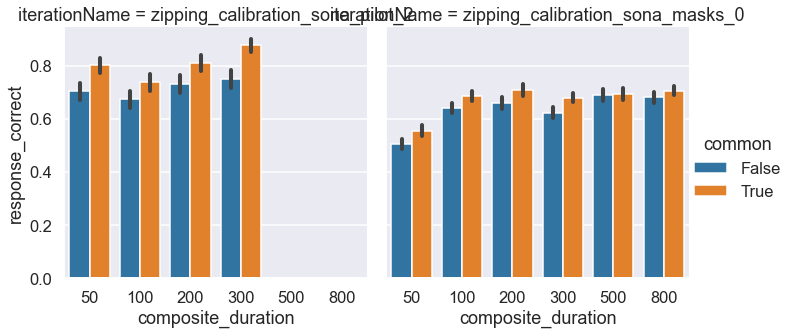

In [111]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            col = 'iterationName',
              y="response_correct", 
              x="composite_duration",
              hue="common",
              kind='bar')

<Figure size 720x432 with 0 Axes>

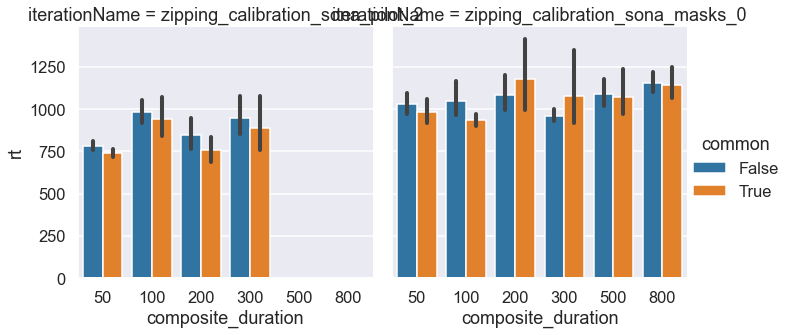

In [112]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            col = 'iterationName',
              y="rt", 
              x="composite_duration",
              hue="common",
              kind='bar')

### What is performance like across the task? Do people get better?

Not obviously...

<Figure size 720x432 with 0 Axes>

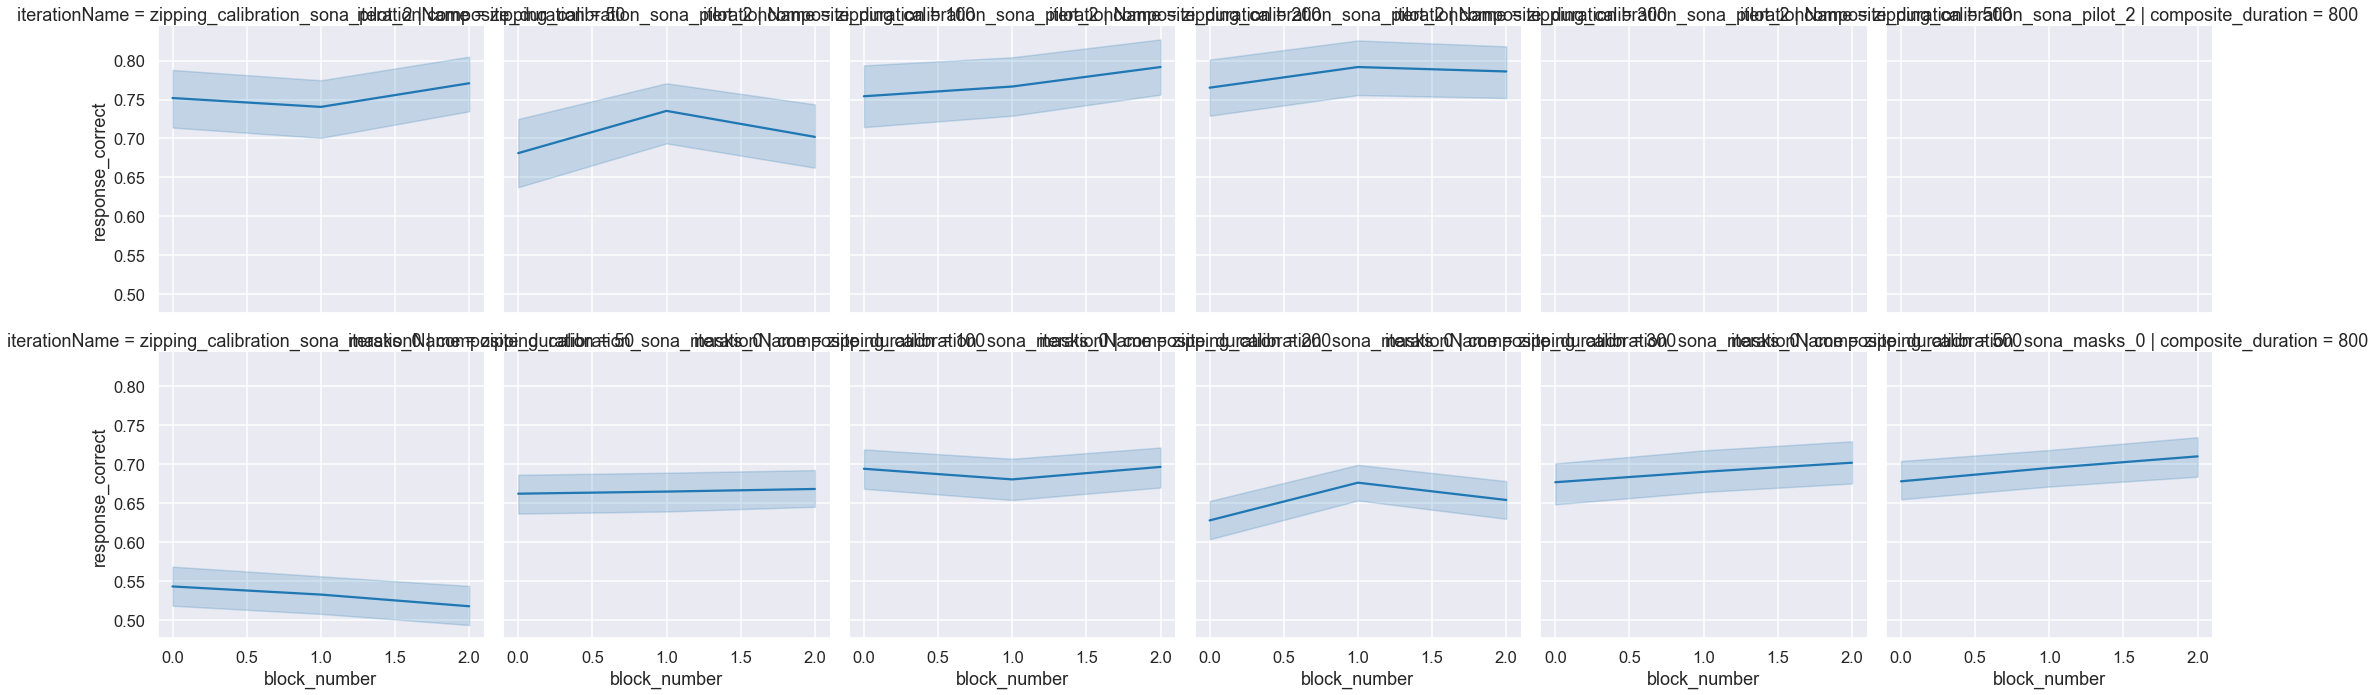

In [78]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip, 
             row = 'iterationName',
             col = 'composite_duration',
               y = "response_correct", 
               x = "block_number",
            kind = 'line')

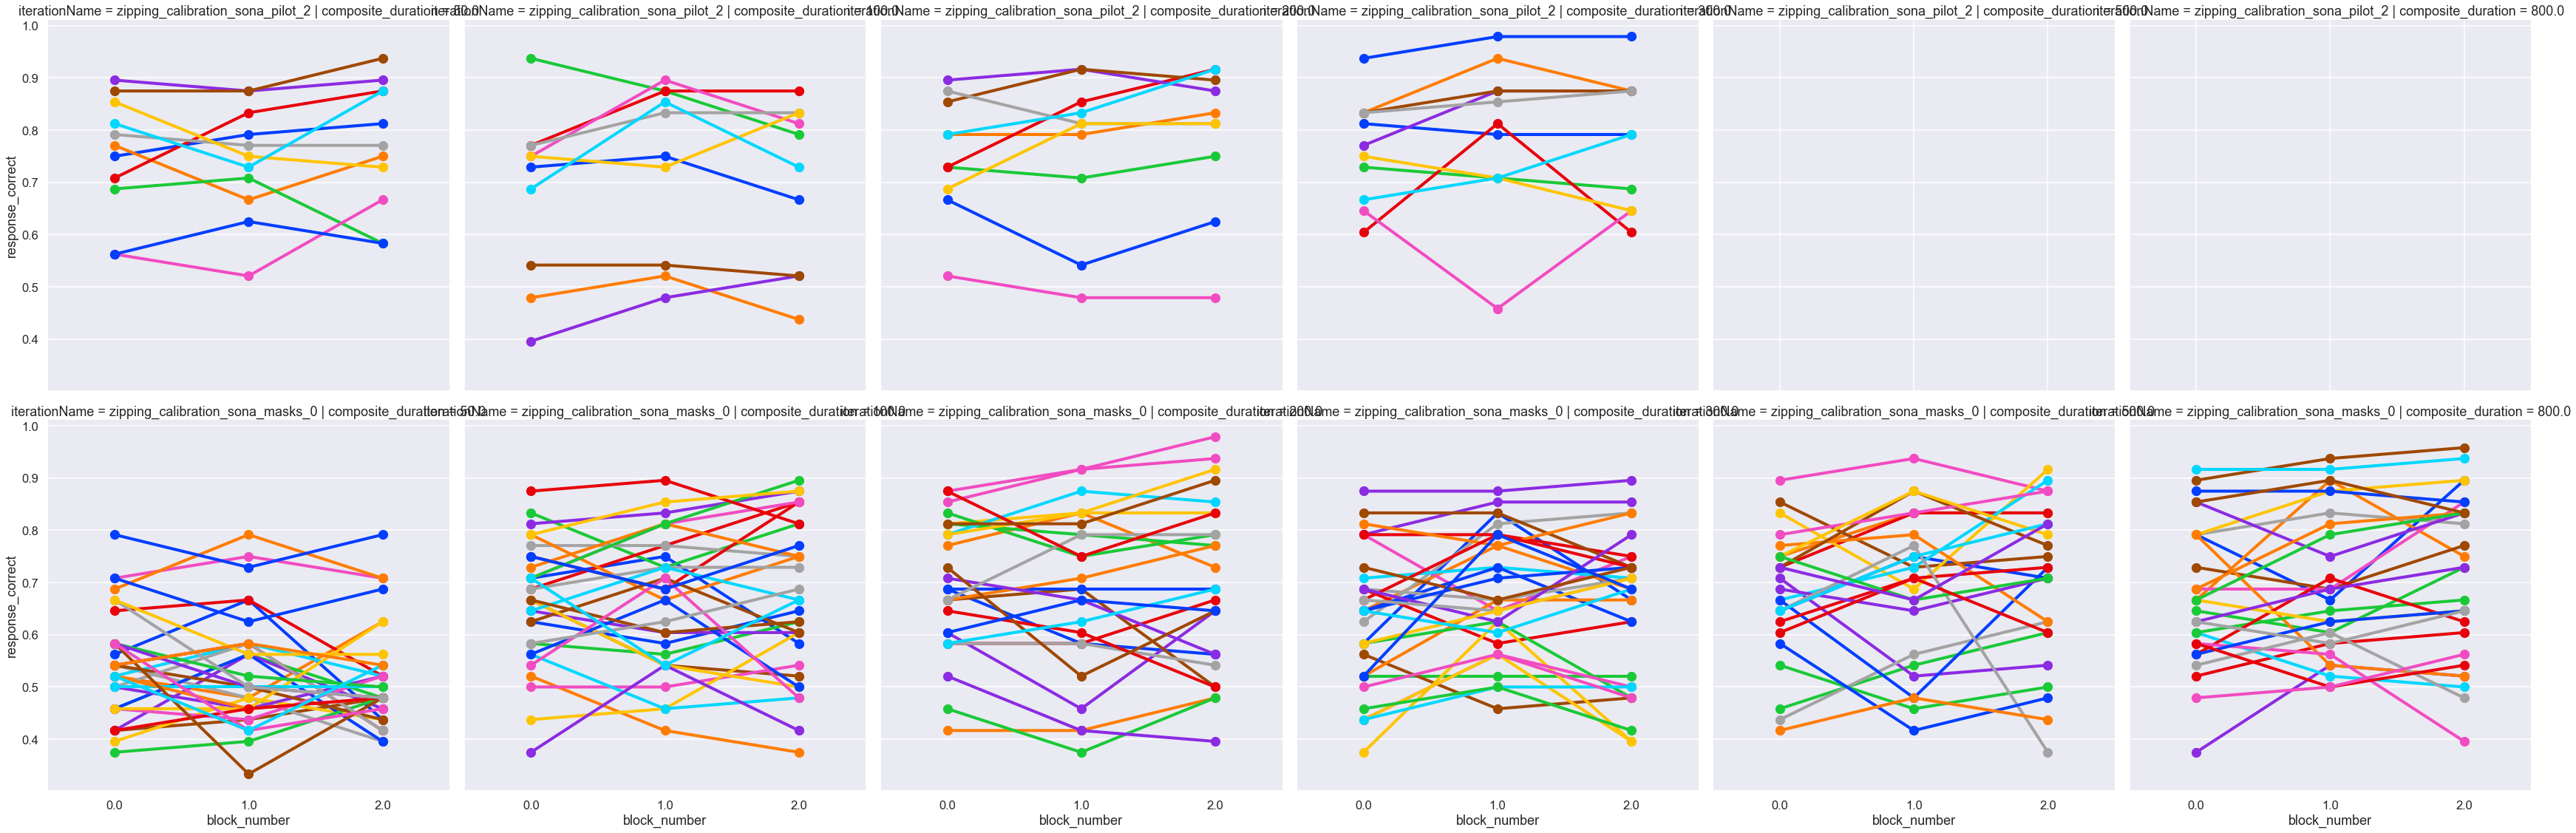

In [94]:
g = sns.FacetGrid(df_zip_block_mean, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8)

g.map_dataframe(sns.pointplot,
                  y="response_correct",
                  x="block_number",
                  hue="gameID",
                  palette="bright")

<Figure size 720x432 with 0 Axes>

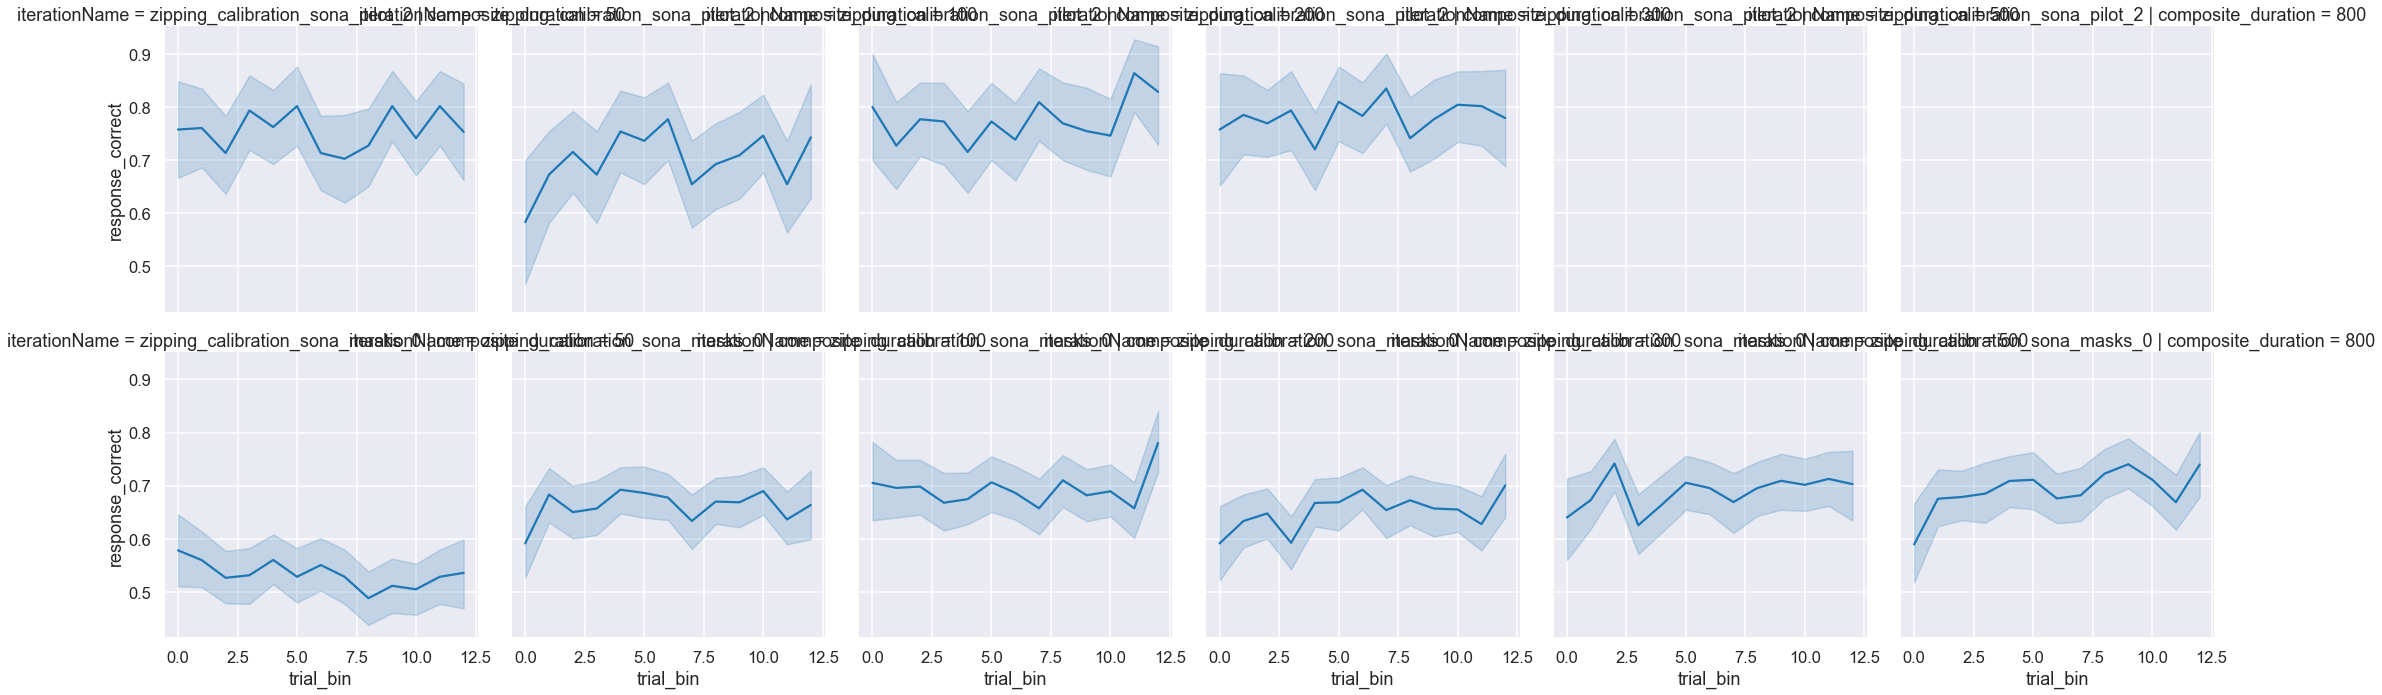

In [76]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip, 
             row = 'iterationName',
             col = 'composite_duration',
               y = "response_correct", 
               x = "trial_bin",
            kind = 'line')

<Figure size 720x432 with 0 Axes>

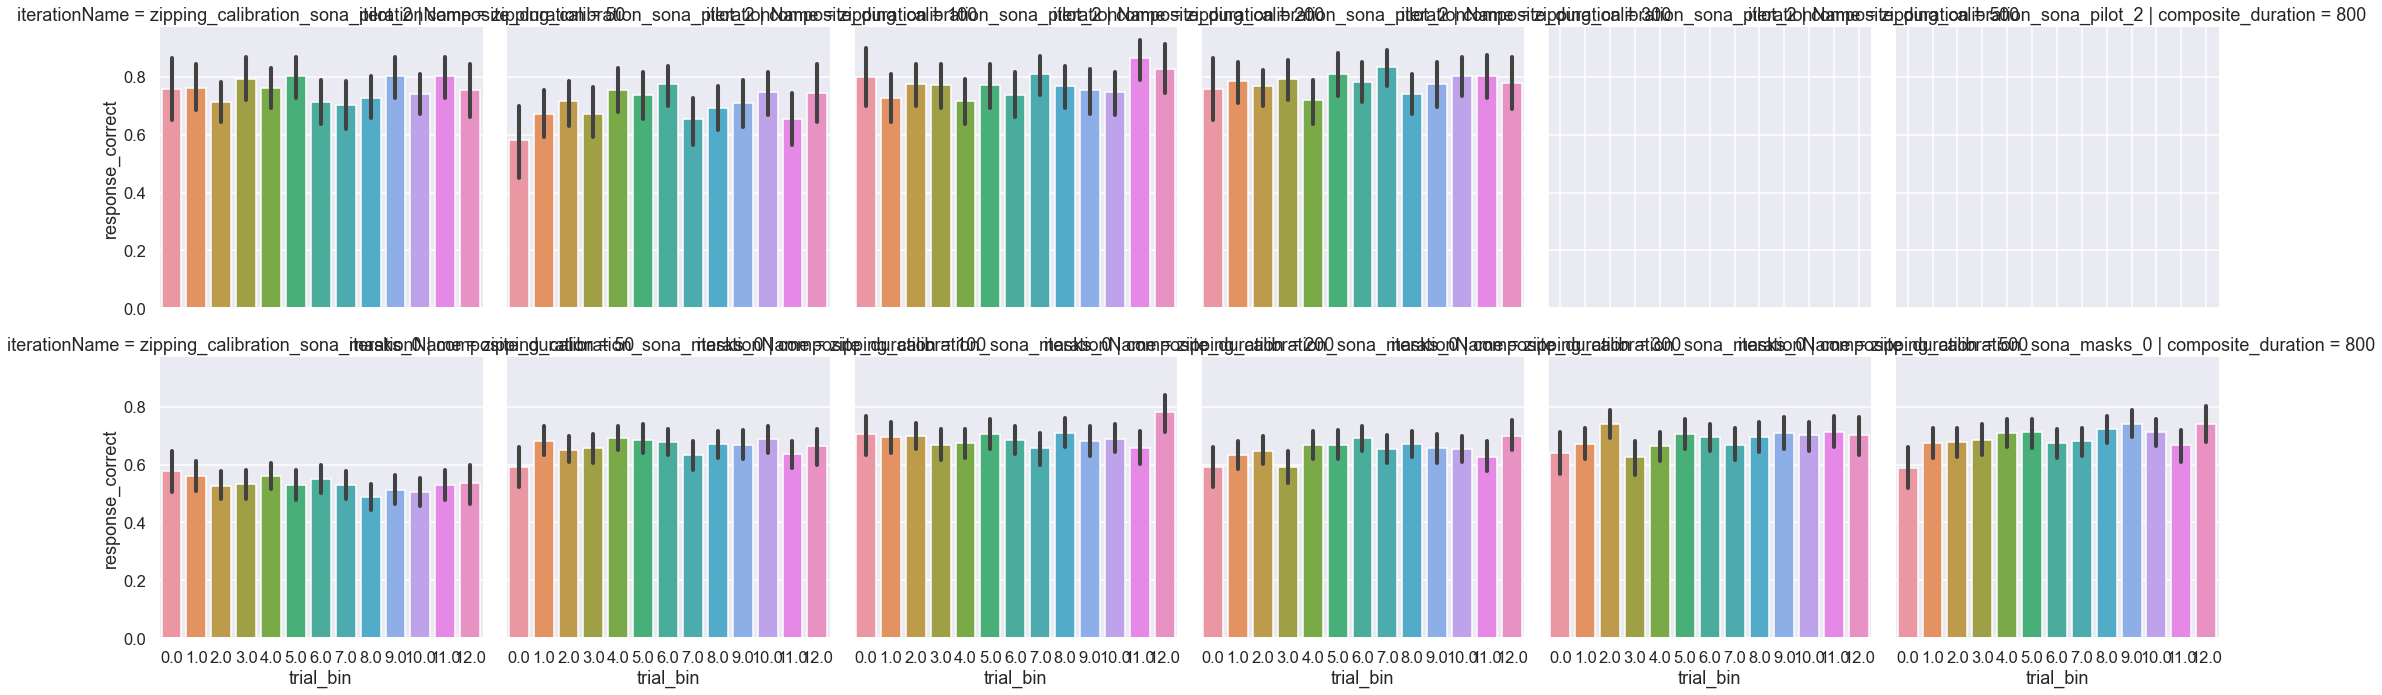

In [77]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data = df_zip, 
             row = 'iterationName',
             col = 'composite_duration',
               y = "response_correct", 
               x = "trial_bin",
            kind = 'bar')

#### Do masks or composite duration affect whether people improve at only the common trials?

This is the key question. We are expecting to see people start the same then diverge as they become better at the common trials...

... this doesn't seem to be happening.

<Figure size 720x432 with 0 Axes>

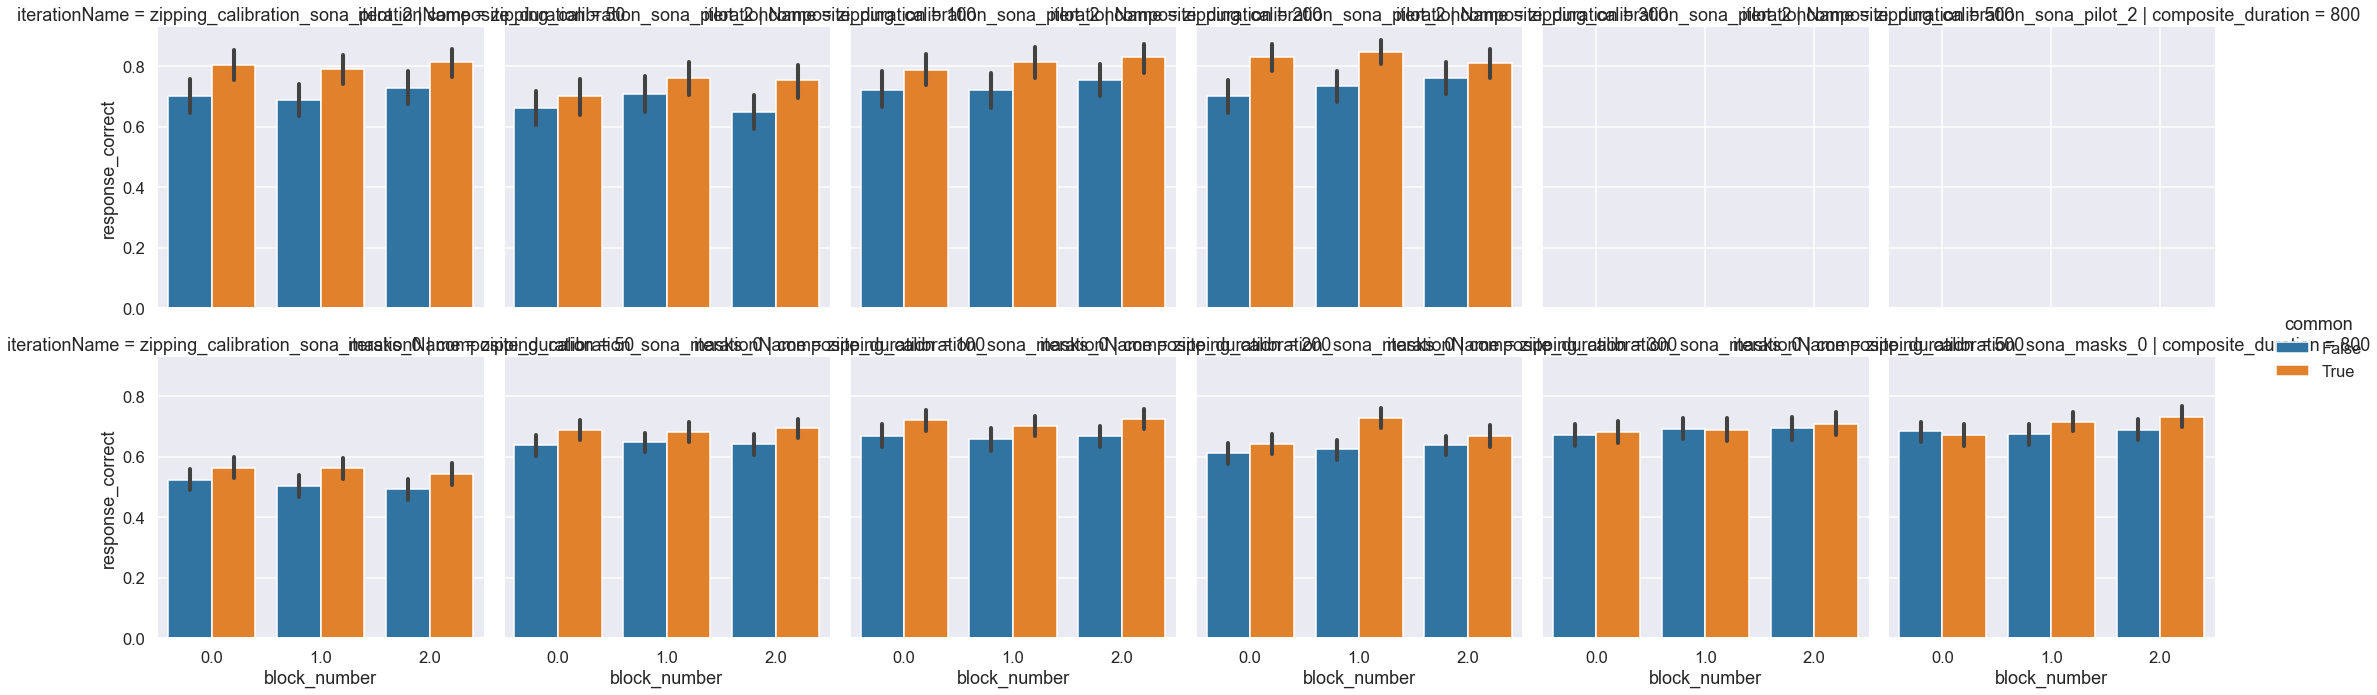

In [67]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            row = 'iterationName',
            col = 'composite_duration',
            hue = 'common',
              y="response_correct", 
              x="block_number",
              kind='bar')

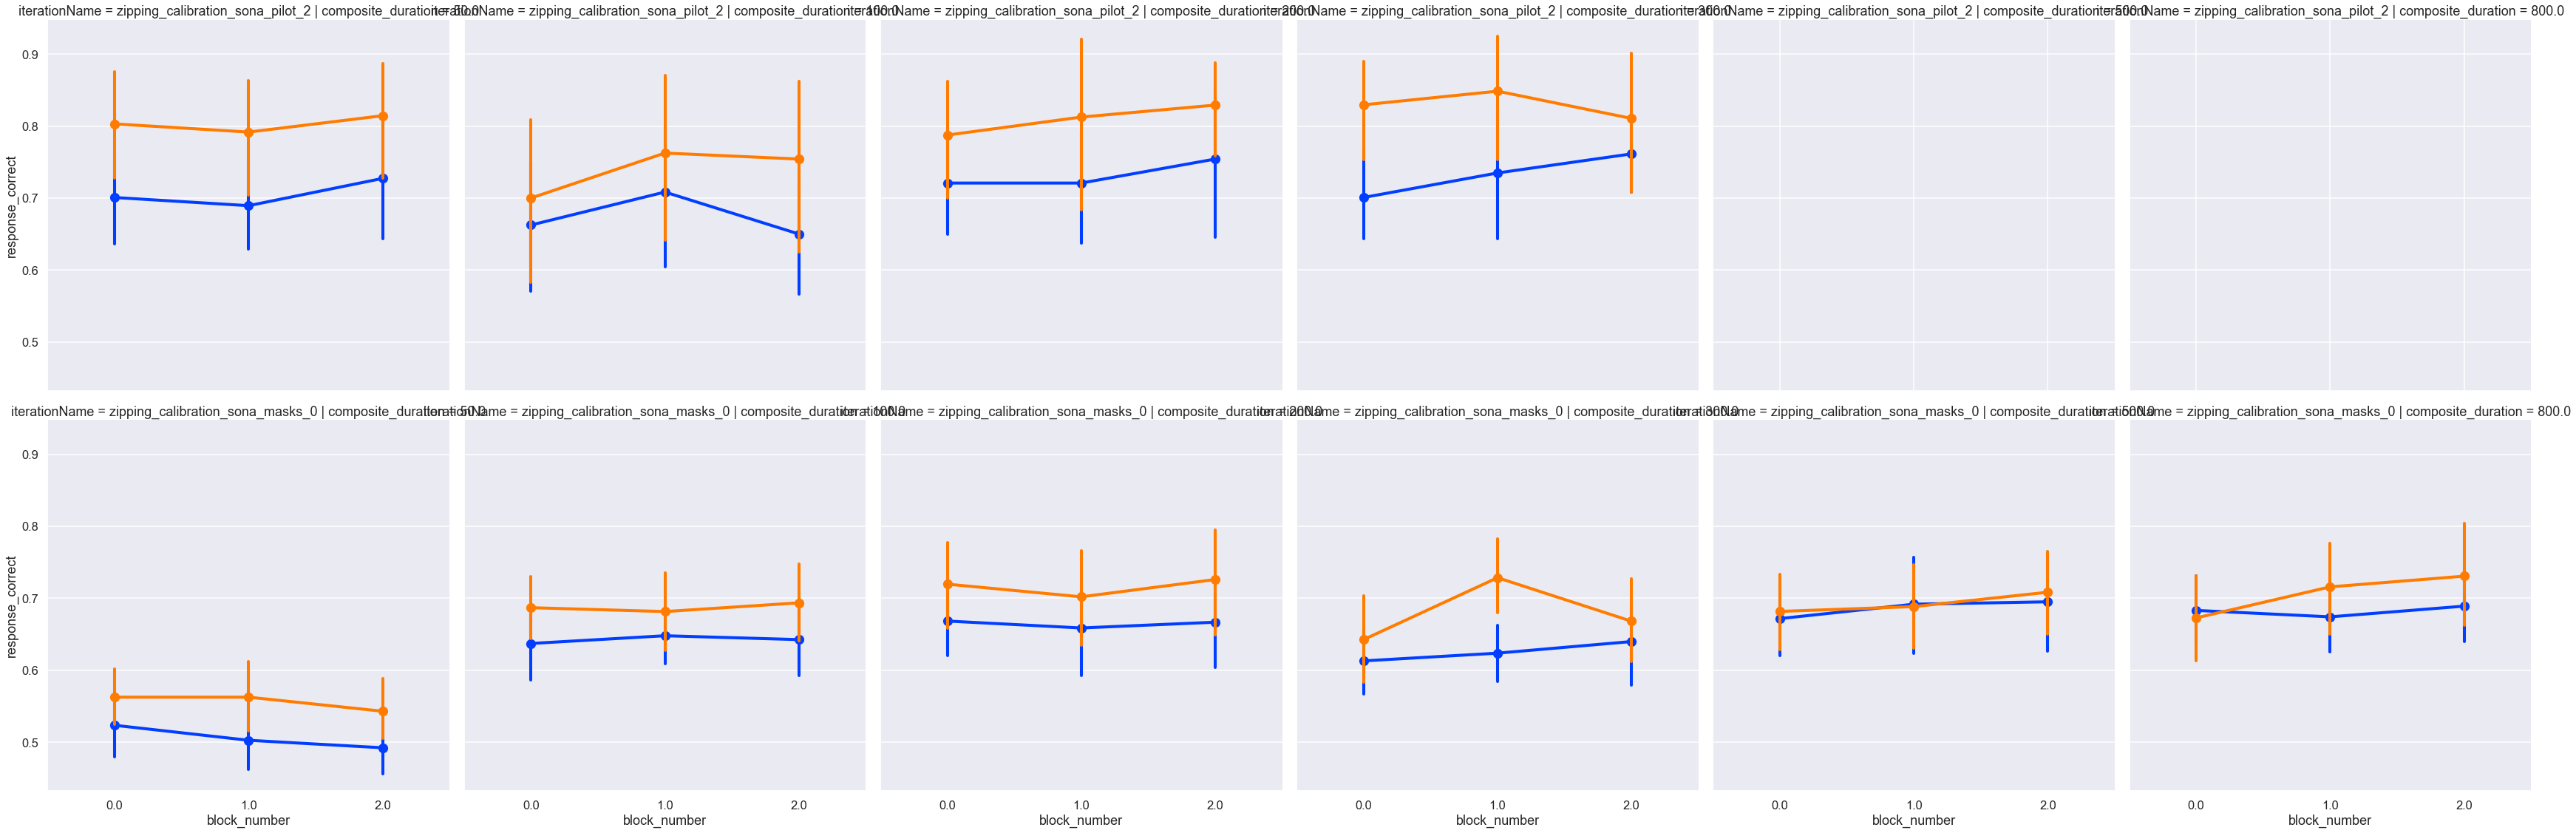

In [96]:
g = sns.FacetGrid(df_zip_block_common_mean, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8)

g.map_dataframe(sns.pointplot,
                  y="response_correct",
                  x="block_number",
                  hue="common",
                  palette="bright")

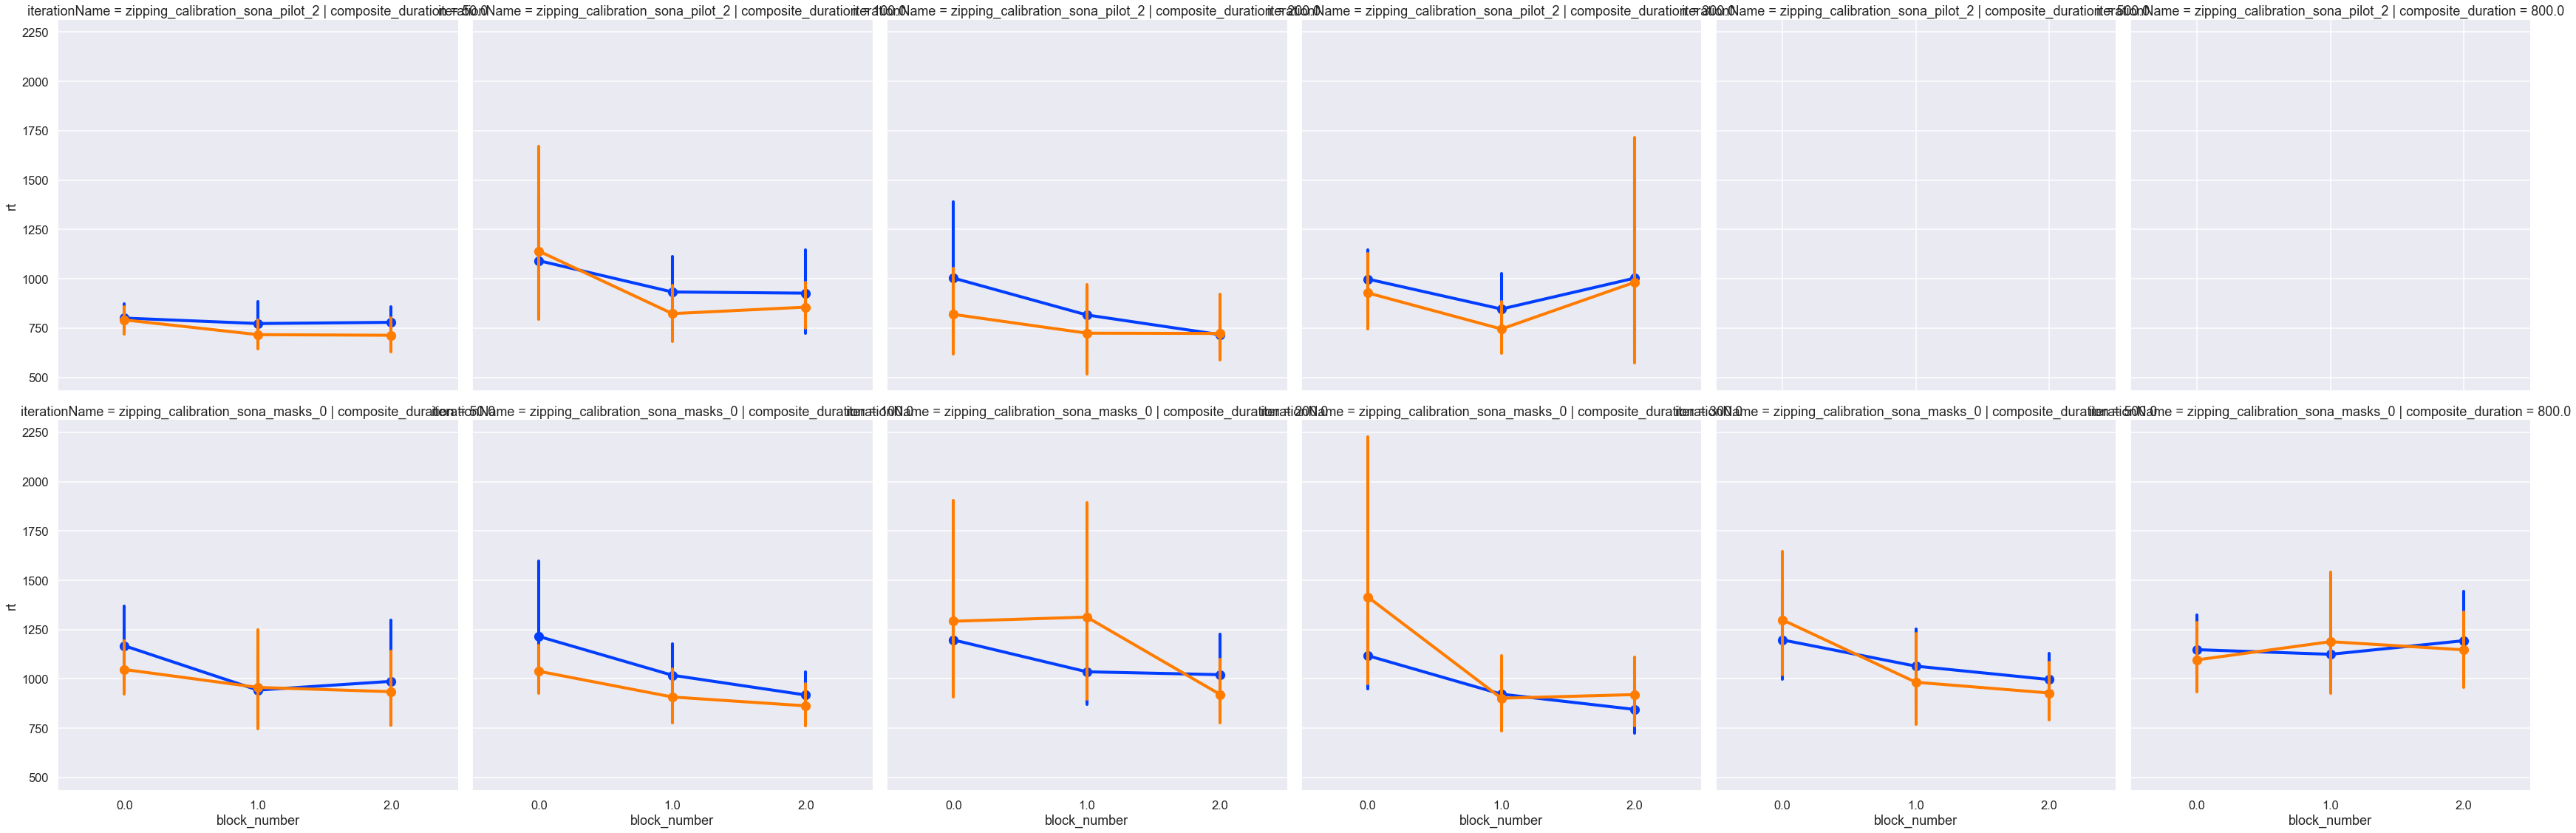

In [107]:
g = sns.FacetGrid(df_zip_block_common_mean, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8)

g.map_dataframe(sns.pointplot,
                  y="rt",
                  x="block_number",
                  hue="common",
                  palette="bright")

It's a little suspect that common is less accurate than rare in the first block. Are people just learning really quickly?

It looks like this might be happening:

<Figure size 720x432 with 0 Axes>

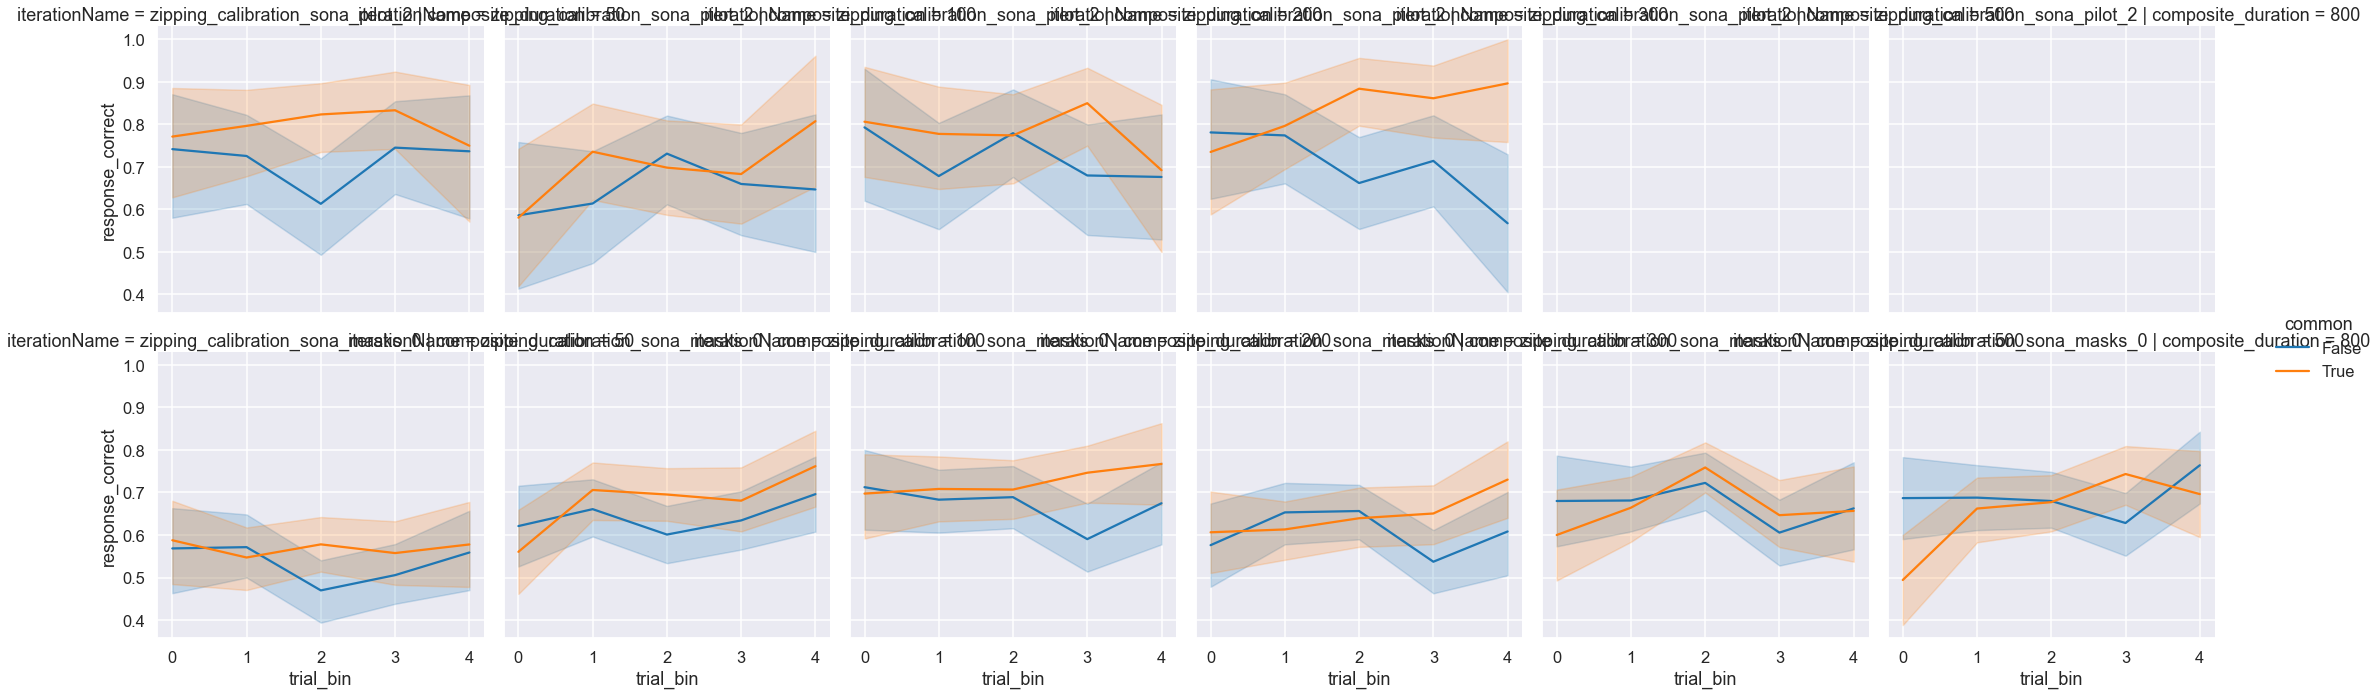

In [98]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip[df_zip.trial_num < 48], 
             row = 'iterationName',
             col = 'composite_duration',
             hue = 'common',
               y = "response_correct", 
               x = "trial_bin",
            kind = 'line')

<Figure size 720x432 with 0 Axes>

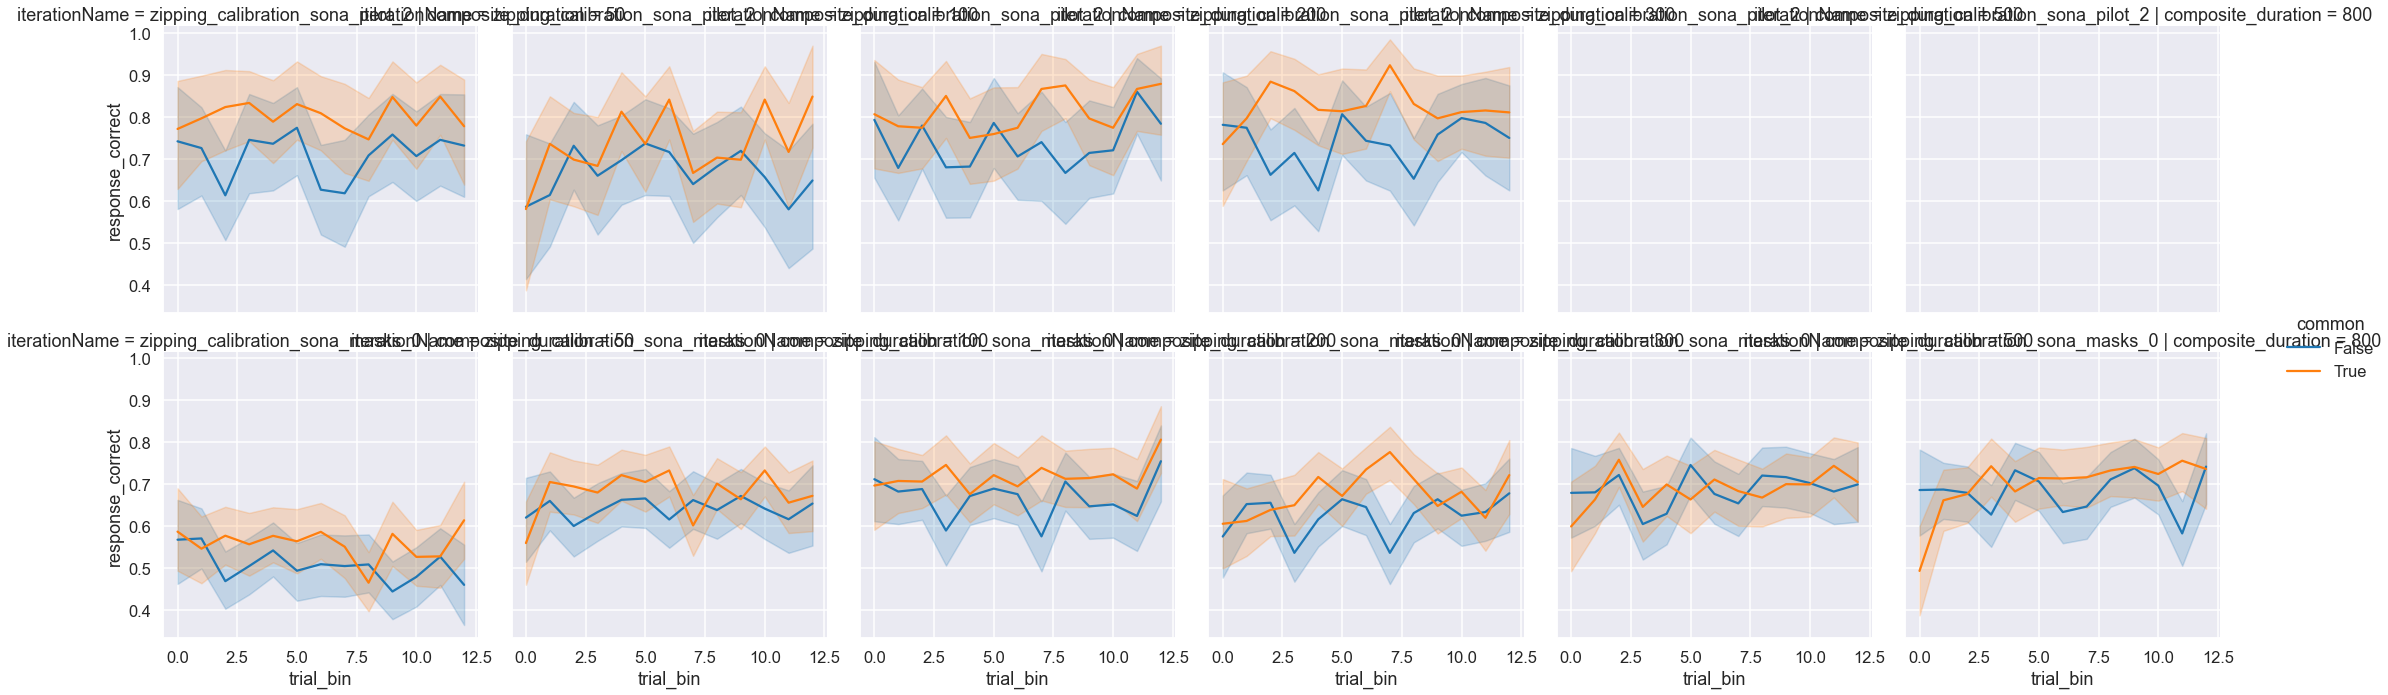

In [73]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip, 
             row = 'iterationName',
             col = 'composite_duration',
             hue = 'common',
               y = "response_correct", 
               x = "trial_bin",
            kind = 'line')

## Questions to ask

What is this manipulation doing?
It's giving participants a lot of experience with a particular shape.
In theory, in decomposing it in a particular direction.
This is passive learning.
What do we expect because of this? We expect that decomposing this stimulus in this direction will be faster. (all trials for this one are in the "compatible direction").
i.e we expect that towards the end of the experiment, common trials will be faster than rare trials.


When do we expect rare/common to play a role? Only towards the end.
How much of a difference do we expect?


#### Overall impressions of task
How hard/ easy is this task?
How hard/easy do we expect it to be, and does this match the performance we see?


#### Will this paradigm work?
Is there a large enough RT gap in any version such that we have space to ask questions about the effect of building?

If not, are there different versions of the experiment for which this gap could be larger?
Are there any trends?

Is the pattern of RTs the same across all experiments?
In which situations the largest gaps in RT occur?


Do people perform better (speed, accuracy, d') in any particular version of the experiment?


#### Stim duration- are we looking in the right range?
Does more time looking at the stimulus make you better at this task?
Is there a sweet spot?


#### Masks
What are the masks doing?
Do they make the task harder?
Do they make the task harder in specific situations?

Masks weren meant to prevent afterimages from making this task easy.
What does this mean? We're testing if people prioritize decomposition into parts they've built.



How easy is this task?

In [21]:
df_zip.columns

Index(['_id', 'rt', 'stimulus', 'response', 'response_correct', 'stimURL',
       'practice', 'composite_id', 'composite_duration', 'gap_duration',
       'chunk_duration', 'participant_condition', 'compatible_trial',
       'validity', 'part_type', 'part_a', 'part_b', 'stimVersion',
       'stimVersionInd', 'compatible_condition', 'trial_num', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'datatype',
       'experimentName', 'iterationName', 'workerID', 'gameID', 'block_number',
       'condition', 'composite_talls_name', 'response_key_dict', 'mask'],
      dtype='object')

In [45]:
response_ratios = \
df_zip.groupby(['gameID','response']).apply(len).groupby('gameID').first()/\
df_zip.groupby(['gameID','response']).apply(len).groupby('gameID').last()

(array([  1.,   0.,   0.,   3.,  18., 117.,  55.,  14.,   1.,   1.]),
 array([-3.00284974, -2.47668652, -1.9505233 , -1.42436008, -0.89819686,
        -0.37203364,  0.15412959,  0.68029281,  1.20645603,  1.73261925,
         2.25878247]),
 <BarContainer object of 10 artists>)

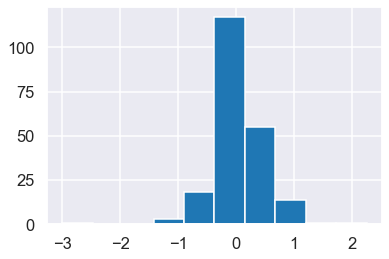

In [47]:
plt.hist(np.log(response_ratios))